In [ ]:
# Pennylane
try:
  import pennylane as qml
  from pennylane import numpy as np
except ImportError:
  %pip install pennylane
  import pennylane as qml
  from pennylane import numpy as np
# Plotting
import matplotlib.pyplot as plt

from scipy.optimize import minimize
import math


n_qubits = 3 # Number of system qubits.
acc = 3 # Number of digits of accuracy
n_shots = 10 ** (acc*2)  # Number of quantum measurements.
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).
q_delta = 0.1  # Initial spread of random quantum weights
eta = 0.1 # Sparsity penalty term
num_layers = 3 # Number of layers defining variational ansatz

dev = qml.device("lightning.qubit", wires=tot_qubits)

eps = 0.01 # Required epsilon for minimizer thresholding

# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = np.array([2.5, -1, -1, -0.5])

A_num = np.zeros((2**n_qubits, 2**n_qubits))
for idx in range(2**n_qubits):
    A_num[idx, idx] = 2

for m in range(2**n_qubits):
    for n in range(2**n_qubits):
        if abs(m - n) == 1:
            A_num[m, n] = -1

b = np.ones(2**n_qubits) / np.sqrt(2**n_qubits)

print("A = \n", np.real(A_num))
print("b = \n", b)
cond = np.linalg.cond(A_num)
print(str(cond))
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

c_probs = (x / np.linalg.norm(x)) ** 2

def U_b():
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def U_badj():
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)


# Defines an C_i matrix, which will comprise an L2 matrix for the
# high-entanglement decomposition of the Poisson
def CI(i):
    for j in range(i):
        qml.MultiControlledX(wires=[ancilla_idx, i, i-1-j])
    qml.MultiControlledX(wires=[ancilla_idx] + [x for x in range(i)] + [i])
    for j in range(i):
        qml.MultiControlledX(wires=[ancilla_idx, i, j])

# L3 matrix for the high-entanglement decomposition of the poisson
# THIS ONE IS THE REASON THE RESULTS HAVE TO BE REVERSED.
# eventually we will want to invert this so we don't have to reverse the outputs
def L3():
    qml.Hadamard(wires=ancilla_idx)
    qml.MultiControlledX(wires=[x for x in range(n_qubits+1)])
    qml.Hadamard(wires=ancilla_idx)

    for i in range(n_qubits):
        qml.CNOT(wires=[ancilla_idx, i])

    qml.Hadamard(wires=ancilla_idx)
    qml.MultiControlledX(wires=[x for x in range(n_qubits+1)])
    qml.Hadamard(wires=ancilla_idx)

    for i in range(n_qubits):
        qml.CNOT(wires=[ancilla_idx, i])


def L3_adj():
    for i in range(n_qubits):
        qml.CNOT(wires=[ancilla_idx, i])

    qml.Hadamard(wires=ancilla_idx)
    qml.MultiControlledX(wires=[x for x in range(n_qubits+1)])
    qml.Hadamard(wires=ancilla_idx)

    for i in range(n_qubits):
        qml.CNOT(wires=[ancilla_idx, i])

    qml.Hadamard(wires=ancilla_idx)
    qml.MultiControlledX(wires=[x for x in range(n_qubits+1)])
    qml.Hadamard(wires=ancilla_idx)

def CA(idx):
    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if idx == 0:
        # Identity operation
        None

    elif idx == 1:
        # L1
        qml.CNOT(wires=[ancilla_idx, 0])

    elif idx == 2:
        # L2 matrix
        for i in range(1, n_qubits):
            CI(i)

    elif idx == 3:
        # L3tilda matrix
        L3()


def CA_adj(idx):
    if idx == 0:
        None
    elif idx == 1:
        qml.CNOT(wires=[ancilla_idx, 0])
    elif idx == 2:
        for i in reversed(range(1, n_qubits)):
            CI(i)
    elif idx == 3:
        L3_adj()

# TRADITIONAL ANSATZ
def variational_block(weights):

    if len(weights) != n_qubits + 3*n_qubits + 3*(n_qubits-2):
        print("WRONG WEIGHTS")
    w1 = weights[:n_qubits]
    wl1 = weights[n_qubits:(3*n_qubits-2)]
    wl2 = weights[(3*n_qubits-2):(5*n_qubits-4)]
    wl3 = weights[(5*n_qubits-4):(7*n_qubits-6)]
    for q in range(n_qubits):
        qml.RY(weights[q], wires=q)

    for wl in [wl1, wl2, wl3]:
        for q in range(0, n_qubits-1, 2):
            qml.CZ(wires=[q, q+1])

        for q in range(n_qubits):
            qml.RY(wl[q], wires=q)

        for q in range(1, n_qubits-1, 2):
            qml.CZ(wires=[q, q+1])

        for q in range(1, n_qubits-1):
            qml.RY(wl[q+n_qubits-1], wires=q)

# PROBLEM-SPECIFIC ANSATZ (EXPERIMENTAL, UNUSED IN PAPER)
def variational_block1(weights):
    if len(weights) != (n_qubits-1):
        print("EXP VAR BLOCK. WRONG WEIGHT")

    qml.Hadamard(wires=[n_qubits-1])

    for q in range(n_qubits-1):
        qml.RY(weights[q], wires=q)
        #qml.RY(abs((weights[q])+1.21), wires=q)
        qml.CNOT(wires=[n_qubits-1, q])


    qml.PauliX(wires=[n_qubits-1])

# GLOBAL-ENTANGLING ANSATZ
def variational_block2(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""

    if len(weights) < n_qubits * num_layers:
        print("Not enough weights!")

    # Using num_layers layers for variational ansatz
    for layer in range(num_layers):
        # Layer of rotation gates
        for idx, element in enumerate(weights[layer*n_qubits:(layer+1)*n_qubits]):
            qml.RY(element, wires=idx)

        # Applying entanglement layer to all but the last layer
        if layer < (num_layers-1):
            for idx in range(n_qubits):
                # Essentially vary the entanglement by the number
                # of layers we choose for the ansatz.
                layer_idx = layer % n_qubits
                if layer_idx != idx:
                    qml.CZ(wires=[layer_idx, idx])

def had_test(dev, weights, l, lp, j, part):
    # For calculating < psi | psi >
    @qml.qnode(dev, interface="autograd")
    def _had_test(weights, l, lp, j, part):

        qml.Hadamard(wires=ancilla_idx)

        if part == "Im" or part == "im":
            qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

        # Initial state = V | 0 >
        variational_block(weights)

        # Unitary to control = A_lp_adj A_l
        CA(l)

        U_badj()

        if j != -1:
            qml.CZ(wires=[ancilla_idx, j])

        U_b()

        CA_adj(lp)

        qml.Hadamard(wires=ancilla_idx)

        return qml.expval(qml.PauliZ(wires=ancilla_idx))
    #display(qml.draw(_had_test)(weights,l,lp,j, part))
    return _had_test(weights, l, lp, j, part)

def had_total(dev, weights, l, lp, j):
    had_real = had_test(dev, weights, l, lp, j, "Re")
    had_imag = had_test(dev, weights, l, lp, j, "Im")

    return had_real + 1.0j * had_imag

def psi_psi(weights):

    res = 0

    # Add all l and lp s.t. l != lp and lp > l
    for l in range(len(c)):
        for lp in range(l+1, len(c)):
            res += 2 * c[l] * np.conj(c[lp]) * had_total(dev, weights, l, lp, -1)

    # Add the remaining result of the summations
    for ind in range(len(c)):
        res += c[ind] * np.conj(c[ind])

    return abs(res)

def mu_sum(weights):
    res = 0

    for l in range(0, len(c)):
        for lp in range(l, len(c)):
            for j in range(n_qubits):
                if l == lp:
                    res += c[l] * np.conj(c[lp]) * had_total(dev, weights, l, lp, j)
                else:
                    res += 2 * c[l] * np.conj(c[lp]) * had_total(dev, weights, l, lp, j)
    return abs(res)

def cost_loc(weights):
    global cost, w, evals
    evals += 1
    w = weights

    mu_sum_val = mu_sum(weights)
    psi_psi_val = psi_psi(weights)

    cost = 0.5 - 0.5 * mu_sum_val / (n_qubits * psi_psi_val)
    return cost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 50.2 MB/s eta 0:00:00
A = 
 [[ 2. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  2.]]
b = 
 [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
32.16343747752639


In [ ]:
# TESTING DIFFERENT OPTIMIZERS

q_delta = 0.1
gamma = (eps ** 2) / (cond ** 2)

class GammaCondition(Exception):
    pass

def log_cost(x):
    global cost, cost_history
    cost_history.append(cost)
    print(cost)
    if cost <= gamma:
        raise GammaCondition

opts = ["L-BFGS-B", "CG", "Powell"]
global w

#w = [-0.22296879,  1.39700563, -1.86268021, -1.69595003,  1.33466046,  0.58702013,
# -1.37133891, -0.31573189,  1.67787141]
cost_history_all = []
for opt in opts:
    best_cost = 10
    best_hist = []
    print(opt)
    for num in range(10):
        cost_history = []
        print("Trial: " + str(num+1))
        w = q_delta * np.random.rand(n_qubits*num_layers)
        try:
            out = minimize(cost_loc, x0 = w, method=opt, callback=log_cost)
        except GammaCondition:
            pass
        if cost_history[len(cost_history)-1] < best_cost:
            best_hist = cost_history
            best_cost = best_hist[len(best_hist)-1]

    cost_history_all.append(best_hist)



In [ ]:
for ind in range(len(opts)):
    print(cost_history_all[ind][len(cost_history_all[ind])-1])
    plt.loglog(cost_history_all[ind], label=opts[ind])
plt.ylabel("Cost Function Value")
plt.xlabel("Optimization steps")
plt.title("Cost Function Value vs. Iterations, Local Cost Function")
plt.legend()
plt.show()

Qubits: 3
3.222209913299614e-08
0.020478569153822068
0.003235224135141157
0.0016904174936644978
7.434271101830481e-05
3.7241201220172826e-05
2.755785222746665e-05
2.689679037409798e-05
2.360147397351131e-06
7.362265775356924e-07
1.193030729762512e-09
Final weights: [-0.48825892 -1.16691351 -0.3405507  -1.04119564 -0.07686743  0.1836529
 -0.2161779  -0.78645445 -0.36602979 -1.51912984  0.01621259 -0.4155713
  0.04660013  0.13327121 -0.00280756]
Qubits: 3
Iterations: 10
Evals: 1611


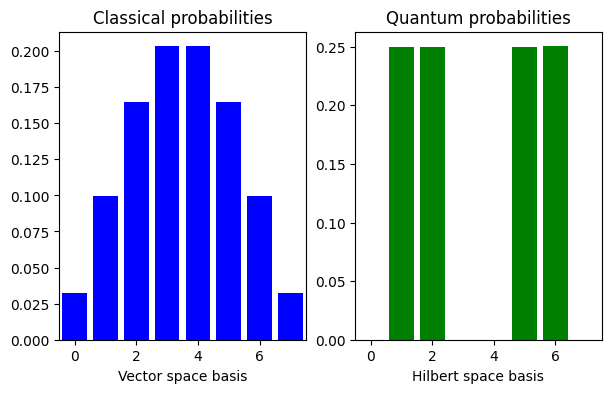

In [ ]:
# TESTING MULTI-QUBIT SYSTEMS

qubits_list = [3] #[x for x in range(3, 10)]
global w

class GammaCondition(Exception):
    pass

def log_cost(x):
    global cost, cost_history
    cost_history.append(cost)
    print(cost)
    if cost <= gamma:
        raise GammaCondition

cost_history_all = []
cost_evals = []
for q in qubits_list:
    global evals
    evals = 0
    cost_history = []
    print("Qubits: " + str(q))

    n_qubits = q  # Number of system qubits.
    tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
    ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).

    w = 0.01*np.random.rand(7*n_qubits - 6)

    dev = qml.device("lightning.qubit", wires=tot_qubits)

    A_num = np.zeros((2**n_qubits, 2**n_qubits))
    for idx in range(2**n_qubits):
        A_num[idx, idx] = 2

    for m in range(2**n_qubits):
        for n in range(2**n_qubits):
            if abs(m - n) == 1:
                A_num[m, n] = -1

    b = np.ones(2**q) / np.sqrt(2**q)

    #print("A = \n", np.real(A_num))
    #print("b = \n", b)
    cond = np.linalg.cond(A_num)

    A_inv = np.linalg.inv(A_num)
    x = np.dot(A_inv, b)

    c_probs = (x / np.linalg.norm(x)) ** 2

    gamma = (eps ** 2) / (n_qubits * (cond ** 2))

    print(gamma)
    try:
        out = minimize(cost_loc, x0 = w, method='Powell', callback=log_cost)
    except GammaCondition:
        pass

    cost_history_all.append(cost_history)
    print("Final weights: " + str(w))
    print("Qubits: " + str(q))
    print("Iterations: " + str(len(cost_history)))
    print("Evals: " + str(evals))

    cost_evals += [evals]

    dev_x = qml.device("lightning.qubit", wires=n_qubits, shots=n_shots)
    @qml.qnode(dev_x, interface="autograd")
    def prepare_and_sample(weights):

        # Variational circuit generating a guess for the solution vector |x>
        variational_block(weights)

        # We assume that the system is measured in the computational basis.
        # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
        # this will be repeated for the total number of shots provided (n_shots)
        return qml.sample()
    raw_samples = prepare_and_sample(w)

    # convert the raw samples (bit strings) into integers and count them
    samples = []
    for sam in raw_samples:
        sam1 = list(sam)
        sam1.reverse()
        samples.append(int("".join(str(bs) for bs in sam1), base=2))

    q_probs = np.bincount(samples) / n_shots

    #print("x_n^2 =\n", c_probs)
    #print("|<x|n>|^2=\n", q_probs)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

    ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
    ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
    ax1.set_xlabel("Vector space basis")
    ax1.set_title("Classical probabilities")

    q_probs = list(q_probs)
    if len(q_probs) < 2**q:
        q_probs.append(0)
    ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
    ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
    ax2.set_xlabel("Hilbert space basis")
    ax2.set_title("Quantum probabilities")

    plt.show()

In [ ]:
print([len(x) for x in cost_history_all])
cond_nums = [32, 116, 440, 1711, 6743, 26767, 106657]
eps = 0.01
plt.semilogy(qubits_list[:len(qubits_list)-1], [abs(x[len(x)-1]) for x in cost_history_all], 'o', label="Final Value")
plt.semilogy(qubits_list[:len(qubits_list)-1], [ eps ** 2 / (x * cond_nums[x-3]**2) for x in range(3, 10)], label="Required Cost for epsilon=0.01")
plt.title("Final Cost Value vs. Qubits")
plt.xlabel("Qubits")
plt.ylabel("Final Cost Value")
plt.legend()
plt.show()

plt.plot(range(3, 10), [len(x) for x in cost_history_all])
plt.xlabel("Qubits")
plt.ylabel("Iterations")
plt.title("Iterations versus Qubits")
plt.show()

plt.plot(range(3, 10), cost_evals)
plt.xlabel("Qubits")
plt.ylabel("Cost Evaluations")
plt.title("Cost Evaluations versus Qubits")
plt.show()

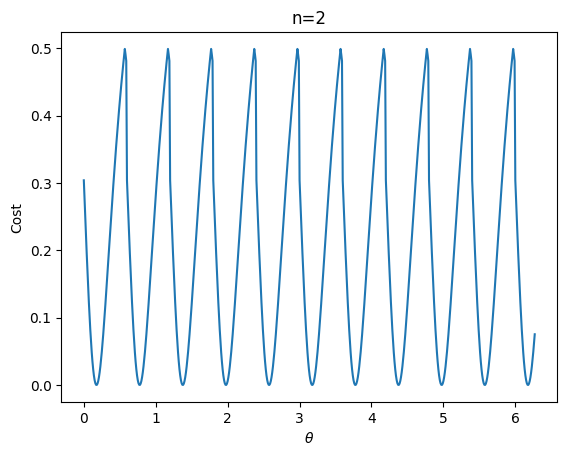

In [ ]:
# GRAPHING COST FUNCTION FOR N=2

values = range(int(2*np.pi*(10**2)))
ind = 0
res = []
for x in values:
    #print(ind)
    ind += 1
    res += [cost_loc([x*(10**(-2))])]

plt.plot([float(x*(10**(-2))) for x in values], res)
plt.title("n=2")
plt.xlabel("$\\theta$")
plt.ylabel("Cost")
plt.show()

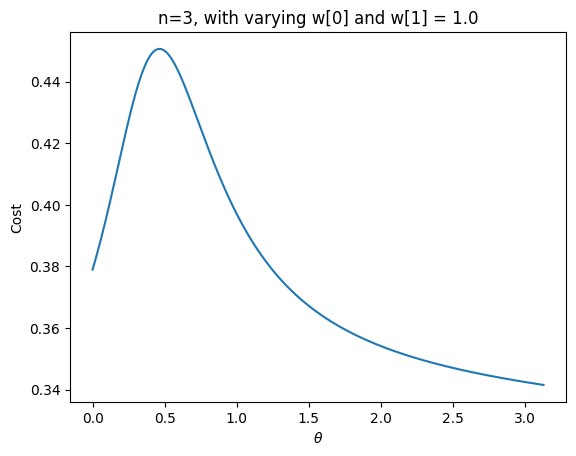

KeyboardInterrupt: 

In [ ]:
# GRAPHING COST FUNCTION FOR N=3

values = range(int(np.pi*(10**2)))

for y in range(0, 314):
    ind = 0
    res = []
    for x in values:
        #print(ind)
        ind += 1
        res += [cost_loc([x*(10**(-2)), y/100])]

    plt.plot([float(x*(10**(-2))) for x in values], res)
    plt.title("n=3, with varying w[0] and w[1] = " + str(y/100))
    plt.xlabel("$\\theta$")
    plt.ylabel("Cost")
    plt.show()

0.4396226053842119
0.4396226053842119
First Max Value: 0.4396226053842119
First Max Index: 2
Min Value: 0.4396226053842119
Min Index: 2
Second Max Value: 0.4396226053842119
Second Max Index: 2


ValueError: x and y must have same first dimension, but have shapes (314,) and (69,)

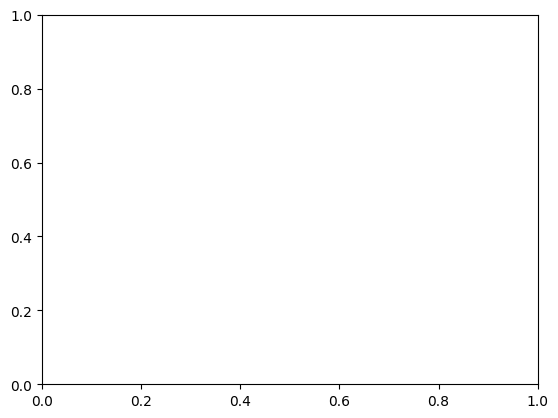

In [ ]:

values = range(int(np.pi*(10**2)))
y = 100
ind = 0
last = 0
curr = 0

# Trying to find the first max in a monotonically increasing function
while curr >= last or ind == 0:
    cost = cost_loc([x*(10**(-2)), y/100])
    print(cost)
    res += [cost]
    last = curr
    curr = cost
    ind += 1

# We exit the loop once the function starts decreasing
print("First Max Value: " + str(last))
print("First Max Index: " + str(ind))


# Trying to find the min in a monotonically decreasing function
while curr <= last:
    cost = cost_loc([x*(10**(-2)), y/100])
    print(cost)
    res += [cost]
    last = curr
    curr = cost
    ind += 1

# We exited once the loop found the minimum
print("Min Value: " + str(last))
print("Min Index: " + str(ind))

# Now we find the second max again, mono inc func
while curr >= last:
    cost = cost_loc([x*(10**(-2)), y/100])
    print(cost)
    res += [cost]
    last = curr
    curr = cost
    ind += 1

print("Second Max Value: " + str(last))
print("Second Max Index: " + str(ind))

plt.plot([float(x*(10**(-2))) for x in values], res)
plt.title("n=3, with varying w[0] and w[1] = " + str(y/100))
plt.xlabel("$\\theta$")
plt.ylabel("Cost")
plt.show()

In [ ]:
max = 0
max_ind = 0
for m in range(100):
    if res[m] > max:
        max = res[m]
        max_ind = m
print(max)
print(values[max_ind]*(10**-2))

print(res[150:])

0.4932108076310783
0.93
[tensor(0.04106041, requires_grad=True), tensor(0.04379956, requires_grad=True), tensor(0.04669837, requires_grad=True), tensor(0.04976605, requires_grad=True), tensor(0.05301236, requires_grad=True), tensor(0.05644765, requires_grad=True), tensor(0.06008292, requires_grad=True)]


In [ ]:
from matplotlib import cm
# sampling rate
sam = 50
values = range(int(0.5*np.pi*sam))
res = np.zeros((len(values), len(values)))
for x in values:
    for y in values:
        res[x, y] = cost_loc([x*(10**(1/sam)), y*(1/sam)])
        print(str(x) + ", " + str(y))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
X, Y = np.array([x*(1/sam) for x in values]), np.array([x*(1/sam) for x in values])
res = np.array(res)
my_col = cm.jet(res/np.amax(res))
surf = ax.plot_surface(X, Y, res, facecolors=my_col)
plt.show()

In [ ]:
# TRYING TO FIND OPTIMAL INITIAL WEIGHTS

from scipy.optimize import minimize

class GammaCondition(Exception):
    pass

def log_cost(x):
    global cost, cost_history
    cost_history.append(cost)
    print("Cost: " + str(cost))
    if cost <= gamma:
        raise GammaCondition

cost_history = []

# THESE WEIGHTS ALLOW FOR CG TO MINIMIZE TO THE CORRECT SOLN
# w = [-0.93141092, -1.51313267, 3.05082505, 2.80546013, 0.35082196, -0.71348385, 0.83058407, 1.98303108, -1.58370546]

# CORRECT
# w = [-0.22296879,  1.39700563, -1.86268021, -1.69595003,  1.33466046,  0.58702013, -1.37133891, -0.31573189,  1.67787141]

# INCORRECT
# w = [-2.10176141e-01,  9.48026536e-02,  1.56797179e+00,  1.15407820e+00,  2.71445852e+00, -6.26763483e-04, -1.83801418e-01,  4.12850764e-01,  1.56652173e+00]

global cost, w

n_qubits = 3 # Number of system qubits.
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).
gamma = (eps ** 2) / (n_qubits * cond ** 2)

dev = qml.device("lightning.qubit", wires=tot_qubits)

n_shots = 10**6
dev_x = qml.device("lightning.qubit", wires=n_qubits, shots=n_shots)

@qml.qnode(dev_x, interface="autograd")
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()



# GLOBAL ENTANGLING ANSATZ
#w = np.pi*np.random.rand(n_qubits*num_layers)

# TRADITIONAL ANSATZ
w = np.pi*np.random.rand(7*n_qubits - 6)

# PROBLEM-SPEC ANSATZ
#w = np.pi*np.random.rand(n_qubits-1)



method = 'Powell'

print("Number of layers: " + str(num_layers))
print("Qubits: " + str(n_qubits))
print("Method: " + str(method))
print("Weights: " + str(w))

try:
    out = minimize(cost_loc, x0 = w, method=method, callback=log_cost)
except GammaCondition:
    pass

print("Final weights " + str(w))
raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []

for sam in raw_samples:
    sam1 = list(sam)
    sam1.reverse()
    samples.append(int("".join(str(bs) for bs in sam1), base=2))

q_probs = np.bincount(samples) / n_shots

q_probs = list(q_probs)
if len(q_probs) < 2**n_qubits:
    q_probs.append(0)

A_num = np.zeros((2**n_qubits, 2**n_qubits))
for idx in range(2**n_qubits):
    A_num[idx, idx] = 2

for m in range(2**n_qubits):
    for n in range(2**n_qubits):
        if abs(m - n) == 1:
            A_num[m, n] = -1

b = np.ones(2**n_qubits) / np.sqrt(2**n_qubits)

print("A = \n", np.real(A_num))
print("b = \n", b)
cond = np.linalg.cond(A_num)
print(str(cond))
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

c_probs = (x / np.linalg.norm(x)) ** 2

print("x_n^2 =\n", c_probs)
print("|<x|n>|^2=\n", q_probs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

q_probs = list(q_probs)
while len(q_probs) < 2**n_qubits:
    q_probs.append(0)
ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

Number of layers: 3
Qubits: 3
Method: Powell
Weights: [0.01514349 0.54076836 2.43096882 0.71584802 1.28364789 0.73304449
 1.64404537 0.09477546 1.49967098 2.43300154 0.20300896 0.06438942
 0.00327942 2.45709394 3.00692505]


KeyboardInterrupt: 

In [ ]:
n_qubits = 2
num_layers = 3
import numpy as np
A_num = np.zeros((2**n_qubits, 2**n_qubits))
for idx in range(2**n_qubits):
    A_num[idx, idx] = 2

for m in range(2**n_qubits):
    for n in range(2**n_qubits):
        if abs(m - n) == 1:
            A_num[m, n] = -1

b = np.ones(2**n_qubits) / np.sqrt(2**n_qubits)

print("A = \n", np.real(A_num))
print("b = \n", b)
cond = np.linalg.cond(A_num)
print(str(cond))
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

c_probs = (x / np.linalg.norm(x)) ** 2

import sympy as sym

had = [[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]]

def had_layer(matrix, n):
    if n == 1:
        return matrix
    else:
        return had_layer(np.kron(matrix, had), n-1)

hads = had_layer(had, 2)

sw = [sym.Symbol("theta_" + str(x)) for x in range(n_qubits*num_layers)]

def sym_Ry(theta):
    return sym.Matrix([[sym.cos(theta/2), -sym.sin(theta/2)], [sym.sin(theta/2), sym.cos(theta/2)]])

Rys = [sym_Ry(sw[x]) for x in range(n_qubits*num_layers)]


#w = [-1.28215459,  1.06465801,  1.82488, -1.08235272, -2.84073917, -2.01011562]
#Rys = [ [[sym.cos(theta/2), -sym.sin(theta/2)], [sym.sin(theta/2), sym.cos(theta/2)]] for theta in w]

Rys_layers = [np.kron(Rys[n_qubits*x], Rys[n_qubits*x + 1])for x in range(num_layers)]
cz = [[1, 0, 0, 0],
      [0, 1, 0, 0],
      [0, 0, 1, 0],
      [0, 0, 0, -1]]

zero_vec = ([1] + [0 for x in range(2**n_qubits - 1)])

ansatz = np.dot(Rys_layers[2], np.dot(cz, np.dot(Rys_layers[1], np.dot(cz, np.dot(Rys_layers[0], np.dot(hads, zero_vec))))))

print(ansatz)



A = 
 [[ 2. -1.  0.  0.]
 [-1.  2. -1.  0.]
 [ 0. -1.  2. -1.]
 [ 0.  0. -1.  2.]]
b = 
 [0.5 0.5 0.5 0.5]
9.472135954999578
[((-0.5*sin(theta_0/2)*sin(theta_1/2) - 0.5*sin(theta_0/2)*cos(theta_1/2) - 0.5*sin(theta_1/2)*cos(theta_0/2) - 0.5*cos(theta_0/2)*cos(theta_1/2))*sin(theta_2/2)*sin(theta_3/2) - (-0.5*sin(theta_0/2)*sin(theta_1/2) - 0.5*sin(theta_0/2)*cos(theta_1/2) + 0.5*sin(theta_1/2)*cos(theta_0/2) + 0.5*cos(theta_0/2)*cos(theta_1/2))*sin(theta_3/2)*cos(theta_2/2) - (-0.5*sin(theta_0/2)*sin(theta_1/2) + 0.5*sin(theta_0/2)*cos(theta_1/2) - 0.5*sin(theta_1/2)*cos(theta_0/2) + 0.5*cos(theta_0/2)*cos(theta_1/2))*sin(theta_2/2)*cos(theta_3/2) + (0.5*sin(theta_0/2)*sin(theta_1/2) - 0.5*sin(theta_0/2)*cos(theta_1/2) - 0.5*sin(theta_1/2)*cos(theta_0/2) + 0.5*cos(theta_0/2)*cos(theta_1/2))*cos(theta_2/2)*cos(theta_3/2))*cos(theta_4/2)*cos(theta_5/2) - (-(-0.5*sin(theta_0/2)*sin(theta_1/2) - 0.5*sin(theta_0/2)*cos(theta_1/2) - 0.5*sin(theta_1/2)*cos(theta_0/2) - 0.5*cos(theta_0/2)*cos(

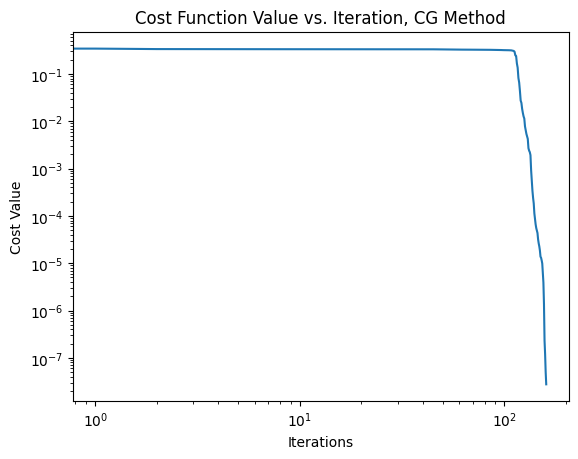

In [ ]:
plt.loglog(cost_history)
plt.title("Cost Function Value vs. Iteration, CG Method")
plt.xlabel("Iterations")
plt.ylabel("Cost Value")
plt.show()

from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/Colab_Notebooks/CG_costs/cost_history_' + str(n_qubits) + '.txt', 'w') as file:
    file.write(str(np.real(cost_history)))

In [ ]:
res = []
with open('/content/drive/MyDrive/Colab_Notebooks/CG_costs/cost_history_' + str(n_qubits) + '.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
         next = line.strip('[]').split(' ')
         for n in next:
            if n:
                res += [float(n)]
print(res)

[0.348070602, 0.34324041, 0.335488589, 0.334358343, 0.333421975, 0.333421202, 0.33340779, 0.333400937, 0.333394604, 0.333390002, 0.333387757, 0.333366898, 0.333353834, 0.333346987, 0.333338149, 0.33333656, 0.333335546, 0.333332958, 0.33333078, 0.333328627, 0.333328127, 0.333326838, 0.333323871, 0.333322568, 0.333321916, 0.333321857, 0.333321191, 0.333320706, 0.333319286, 0.33331767, 0.333317247, 0.33331425, 0.333300562, 0.333289814, 0.333246518, 0.333195443, 0.333117401, 0.332996645, 0.332932819, 0.332850023, 0.332780468, 0.332754329, 0.332672743, 0.332653523, 0.332036146, 0.331655571, 0.331421294, 0.330913673, 0.330746157, 0.330383795, 0.329677419, 0.329576889, 0.32932673, 0.329286005, 0.329095751, 0.328613616, 0.327872084, 0.327700542, 0.327673702, 0.327522469, 0.327211902, 0.326817842, 0.326622853, 0.326204487, 0.32607005, 0.326009479, 0.32597478, 0.325943127, 0.325901069, 0.325862945, 0.325821812, 0.325771628, 0.325742181, 0.325372209, 0.324723678, 0.324534604, 0.324464399, 0.32429

Number of iterations:
15
Final weights:
[-2.10176141e-01  9.48026536e-02  1.56797179e+00  1.15407820e+00
  2.71445852e+00 -6.26763483e-04 -1.83801418e-01  4.12850764e-01
  1.56652173e+00]
Target
9.666629739898855e-08
x_n^2 =
 [0.03252033 0.0995935  0.16463415 0.20325203 0.20325203 0.16463415
 0.0995935  0.03252033]
|<x|n>|^2=
 [0.00000e+00 2.48803e-01 2.49576e-01 2.00000e-06 3.00000e-06 2.51083e-01
 2.50533e-01]


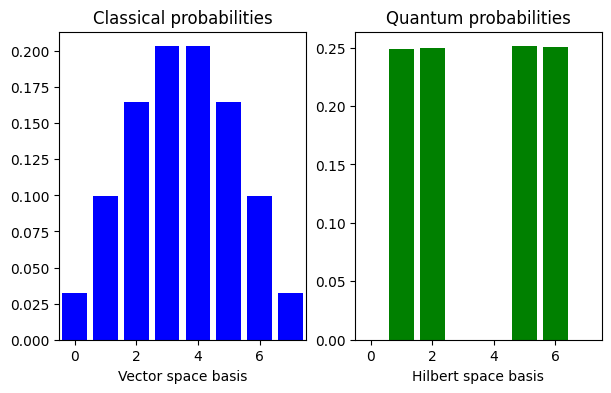

In [ ]:
# For verifying results

print("Number of iterations:")
print(len(cost_history))
print("Final weights:")
print(w)
print("Target")
print(gamma)

n_shots = 10**6
dev_x = qml.device("lightning.qubit", wires=n_qubits, shots=n_shots)

@qml.qnode(dev_x, interface="autograd")
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []
for sam in raw_samples:
    sam1 = list(sam)
    sam1.reverse()
    samples.append(int("".join(str(bs) for bs in sam1), base=2))

q_probs = np.bincount(samples) / n_shots

print("x_n^2 =\n", c_probs)
print("|<x|n>|^2=\n", q_probs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), list(q_probs) + [0], color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()